# Data Pre-Processing

In [70]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ucimlrepo import fetch_ucirepo
import data_handler as dh

In [71]:
bank_marketing = fetch_ucirepo(id=222)
X_bank_marketing, y_bank_marketing = bank_marketing.data.features, bank_marketing.data.targets

wine_quality = fetch_ucirepo(id=186)
X_wine_quality, y_wine_quality = wine_quality.data.features, wine_quality.data.targets

We pre-process the bank marketing data like last week.

In [72]:
X_bank_marketing = X_bank_marketing.drop(['month', 'day_of_week'], axis=1)  # drop features without value for prediction

X_bank_marketing = X_bank_marketing.fillna(0)

X_bank_marketing = pd.get_dummies(X_bank_marketing).astype(np.float64)

X_bank_marketing = (X_bank_marketing - X_bank_marketing.min()) / (
        X_bank_marketing.max() - X_bank_marketing.min())  # normalize the data

y_bank_marketing = y_bank_marketing.copy()
y_bank_marketing['y'] = y_bank_marketing['y'].map({'no': 0, 'yes': 1})  # convert targets to numeric values

In [73]:
X_wine_quality = (X_wine_quality - X_wine_quality.min()) / (X_wine_quality.max() - X_wine_quality.min())
y_wine_quality = (y_wine_quality - y_wine_quality.min()) / (y_wine_quality.max() - y_wine_quality.min())

In [74]:
X_bank_train, X_bank_test, y_bank_train, y_bank_test = dh.split_data(X_bank_marketing, y_bank_marketing, 0.8)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = dh.split_data(X_wine_quality, y_wine_quality, 0.8)

# Regularization

We are going to implement Ridge Regression according to the SGD algorithm on exercise sheet 4. The only difference is that we use 50 samples at once.
For the loss function, we use
$$
Loss = \frac{1}{n} \sum_{i=1}^{n} (Y_i - (X_i \cdot \beta + L_2))^2 + \lambda \sum_{j=1}^{P} \beta_j^2
$$

The gradient with respect to $\beta$ is:

$$
\Delta_{\beta} Loss = - \frac{2}{n} X^T (y - X \beta) + 2 \lambda \beta
$$

The bias term gradient is:

$$
\Delta_{L2} Loss = -\frac{2}{n} \sum_{i=1}^n (y_i - X_i \beta - L2)
$$



In [75]:
class RidgeRegression:
    def __init__(self):
        self.B = None
        self.bias = None

    def fit(self, X_train, y_train, X_test, y_test, initial_learning_rate, regularization_constant, i_max,
            batch_size=50, tolerance=1e-4, clip_value=10):
        """
        
        :param X_train: 
        :param y_train: 
        :param X_test: 
        :param y_test: 
        :param initial_learning_rate: 
        :param regularization_constant: 
        :param i_max: 
        :param batch_size: 
        :param tolerance: 
        :param: clip_value:
        :return: 
        """
        n, d = X_train.shape
        self.B = np.zeros(d)
        self.bias = 0

        train_rmse_history = []
        test_rmse_history = []

        learning_rate = initial_learning_rate
        bold_driver_reward = 1.1
        bold_driver_penalty = 0.5

        for epoch in range(1, i_max + 1):
            indices = np.random.permutation(n)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            prev_rmse = None

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_pred = (X_batch @ self.B) + self.bias

                gradient_B = -(2 / len(y_batch)) * X_batch.T @ (y_batch - y_pred) + 2 * regularization_constant * self.B
                gradient_bias = -(2 / len(y_batch)) * np.sum(y_batch - y_pred)

                # gradient clipping required to prevent overflows lol
                gradient_B_norm = np.linalg.norm(gradient_B)
                if gradient_B_norm > clip_value:
                    gradient_B = (gradient_B / gradient_B_norm) * clip_value

                gradient_bias_norm = np.linalg.norm(gradient_bias)
                if gradient_bias_norm > clip_value:
                    gradient_bias = (gradient_bias / gradient_bias_norm) * clip_value

                B_prev = self.B.copy()
                L2_prev = self.bias

                self.B -= learning_rate * gradient_B
                self.bias -= learning_rate * gradient_bias

                y_batch_pred = (X_batch @ self.B) + self.bias
                rmse_batch = np.sqrt(np.mean((y_batch - y_batch_pred) ** 2))

                # bold driver
                if prev_rmse is not None:
                    if rmse_batch < prev_rmse:
                        learning_rate *= bold_driver_reward
                    else:
                        self.B = B_prev
                        self.bias = L2_prev
                        learning_rate *= bold_driver_penalty

            y_train_pred = self.predict(X_train)
            y_test_pred = self.predict(X_test)
            rmse_train = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
            rmse_test = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

            train_rmse_history.append(rmse_train)
            test_rmse_history.append(rmse_test)

            if len(train_rmse_history) > 1 and abs(train_rmse_history[-2] - train_rmse_history[-1]) < tolerance:
                # print(f"Convergence reached at epoch {epoch}")
                return train_rmse_history, test_rmse_history

        print(f'WARNING: Did not converge after {i_max} epochs!')
        return train_rmse_history, test_rmse_history

    def predict(self, X):
        return X @ self.B + self.bias

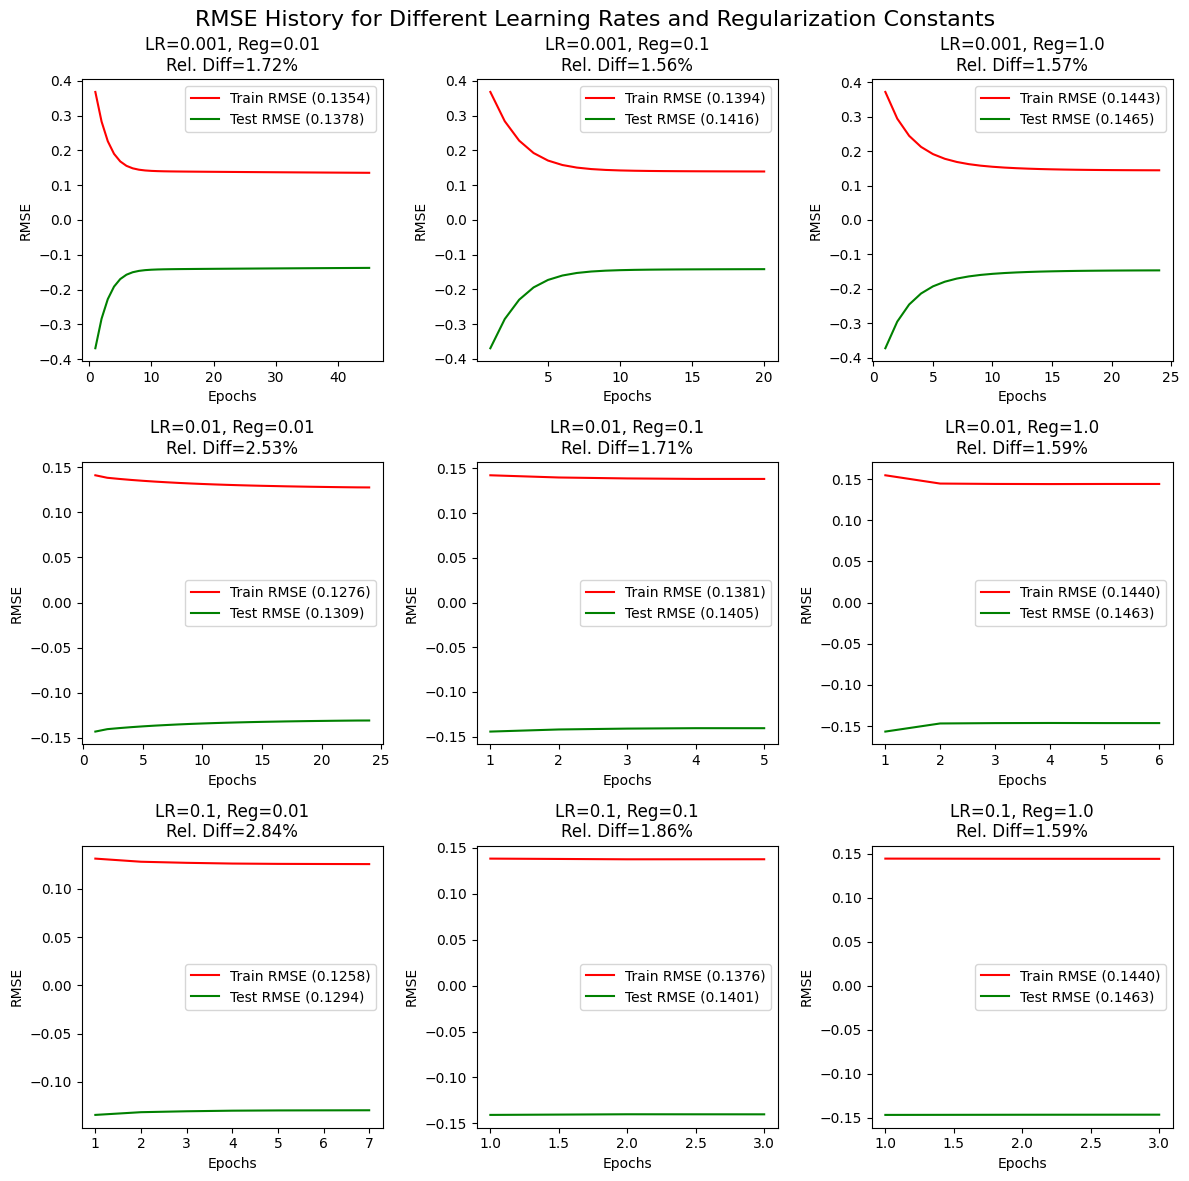

In [76]:
model = RidgeRegression()

learning_rates = [0.001, 0.01, 0.1]
reg_constants = [0.01, 0.1, 1.0]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('RMSE History for Different Learning Rates and Regularization Constants', fontsize=16)

final_test_rmse = []

for i, learning_rate in enumerate(learning_rates):
    for j, reg_constant in enumerate(reg_constants):
        ax = axes[i, j]
        train_rmse_history, test_rmse_history = model.fit(X_wine_train, y_wine_train, X_wine_test, y_wine_test,
                                                          initial_learning_rate=learning_rate,
                                                          regularization_constant=reg_constant, i_max=200
                                                          )
        final_test_rmse.append(test_rmse_history[-1])

        relative_difference = abs(train_rmse_history[-1] - test_rmse_history[-1]) / train_rmse_history[-1]

        ax.plot(range(1, len(train_rmse_history) + 1), train_rmse_history,
                label=f'Train RMSE ({train_rmse_history[-1]:.4f})', color='red')
        ax.plot(range(1, len(test_rmse_history) + 1), -np.array(test_rmse_history),
                label=f'Test RMSE ({test_rmse_history[-1]:.4f})', color='green')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('RMSE')
        ax.set_title(f'LR={learning_rate}, Reg={reg_constant}\nRel. Diff={relative_difference:.2%}')
        ax.legend()

plt.tight_layout()
plt.show()
plt.close()

Test RMSE is, like expected, consistently slightly higher.

We compare our model to sklearn's to further evaluate the performance. 

In [77]:
from sklearn.linear_model import ridge_regression

coef, intercept = ridge_regression(X=X_wine_train, y=y_wine_train, alpha=1,
                                   return_intercept=True)


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


pred = X_wine_test @ coef + intercept
sklearn_rsme = rmse(y_wine_test, pred)

rmse_avg = np.average(final_test_rmse)

print(f'Our average RMSE: {rmse_avg:.4f}, Sklearn RMSE: {sklearn_rsme:.4f}')
print(f'Relative difference: {(rmse_avg - sklearn_rsme) / sklearn_rsme:.4f}')

Our average RMSE: 0.1399, Sklearn RMSE: 0.1258
Relative difference: 0.1126


We see that our model's RMSE is ~ 11% higher than the sklearn model.

# Hyper-parameter Tuning

In [78]:
def k_fold_cross_validation(X, y, learning_rates, reg_cons, k=5, batch_size=50):
    fold_size = len(y) // k

    rmse_scores = np.zeros((len(learning_rates), len(reg_cons)))

    for lr_idx, lr in enumerate(learning_rates):
        for rc_idx, rc in enumerate(reg_cons):
            rmse_fold_history = []

            for fold in range(k):
                start = fold * fold_size
                end = start + fold_size

                X_test = X[start:end]
                y_test = y[start:end].ravel()
                X_train = np.concatenate([X[:start], X[end:]], axis=0)
                y_train = np.concatenate([y[:start], y[end:]], axis=0).ravel()

                model = RidgeRegression()
                _, test_rmse_history = model.fit(X_train, y_train, X_test, y_test, initial_learning_rate=lr,
                                                 regularization_constant=rc, i_max=200, batch_size=batch_size)

                # Append the last RMSE value from the test history
                rmse_fold_history.append(test_rmse_history[-1])

            # Compute the mean RMSE across all folds
            rmse_scores[lr_idx][rc_idx] = np.mean(rmse_fold_history)

    return rmse_scores


learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
reg_cons = [0.0001, 0.001, 0.01, 0.1, 1]

rmse_scores = k_fold_cross_validation(X_wine_quality.to_numpy(), y_wine_quality.to_numpy(), learning_rates, reg_cons)


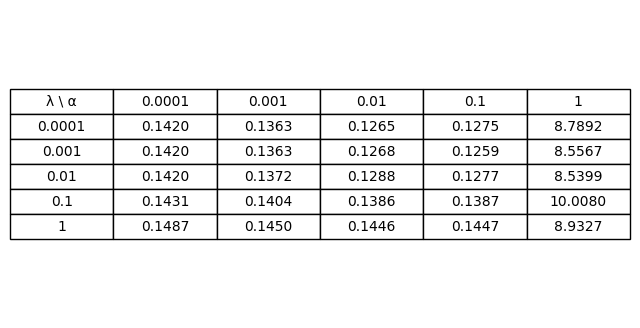

In [79]:
def display_rmse_table(rmse_scores, learning_rates, reg_cons):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')

    table_data = [["λ \\ α"] + [str(lr) for lr in learning_rates]]
    for i, hp in enumerate(reg_cons):
        row = [str(hp)] + [f"{rmse_scores[j, i]:.4f}" for j in range(len(learning_rates))]
        table_data.append(row)

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.show()


display_rmse_table(rmse_scores, learning_rates, reg_cons)

In [80]:
min_idx = np.unravel_index(np.argmin(rmse_scores), rmse_scores.shape)

best_learning_rate = learning_rates[min_idx[0]]
best_reg_cons = reg_cons[min_idx[1]]

print(f'Best Learning Rate: {best_learning_rate:.4f}')
print(f'Best Regularization Constant: {best_reg_cons:.4f}')

Best Learning Rate: 0.1000
Best Regularization Constant: 0.0010


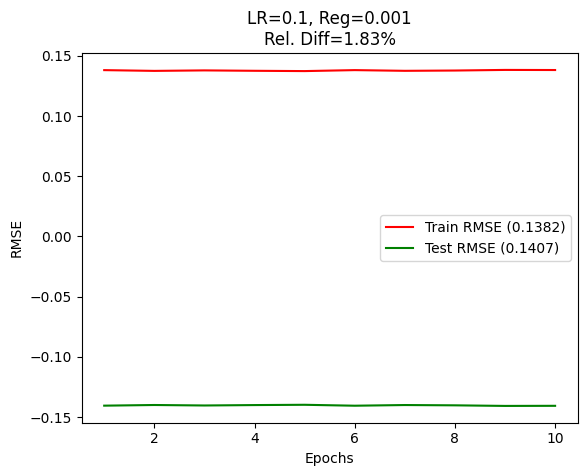

In [81]:
best_model = RidgeRegression()

best_train_rmse_history, best_test_rmse_history = best_model.fit(X_wine_train, y_wine_train, X_wine_test, y_wine_test,
                                                                 initial_learning_rate=best_learning_rate,
                                                                 regularization_constant=best_learning_rate, i_max=200,
                                                                 batch_size=50)

relative_difference = abs(best_train_rmse_history[-1] - best_test_rmse_history[-1]) / best_train_rmse_history[-1]

plt.plot(range(1, len(best_train_rmse_history) + 1), best_train_rmse_history,
         label=f'Train RMSE ({best_train_rmse_history[-1]:.4f})', color='red')
plt.plot(range(1, len(best_test_rmse_history) + 1), -np.array(best_test_rmse_history),
         label=f'Test RMSE ({best_test_rmse_history[-1]:.4f})', color='green')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.title(f'LR={best_learning_rate}, Reg={best_reg_cons}\nRel. Diff={relative_difference:.2%}')
plt.show()
plt.close()